# COVID-19 Fallzahlenanalyse für Deutschland
**Autor: Stefan Koch, Stand: 2020-03-23

Am 17.3. hat das RKI die Darstellung der Fallzahlen geändert. Die bisher verwendete Quelle ist nicht mehr vorhanden. Dadurch kommt es in den nächsten Tagen zu einer ungenauen Extrapolation der Werte.
## Quelle Rohdaten
https://www.rki.de/DE/Content/InfAZ/N/Neuartiges_Coronavirus/Fallzahlen.html
## Datenanalyse

In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import json
from lmfit.models import QuadraticModel, PolynomialModel
plt.style.use('ggplot')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams.update({'font.size': 14})

## Daten einlesen

In [2]:
with open("config.jsn") as json_file:
          cfg = json.load(json_file)

db = psycopg2.connect(user=cfg['user'], password=cfg['password'],
        host=cfg['host'], port=cfg['port'], 
        database=cfg['database'])

df_cases = pd.DataFrame (columns = ['Datum', 'Anzahl' ])
pcursor = db.cursor()
pcursor.execute('SELECT "date","number" FROM "public"."gercases";')
index = 0
while True:
    row = pcursor.fetchone()
    if row is None:
        break
    df_cases.loc[index] = [pd.to_datetime(row[0]), float(row[1])]
    index += 1
df_cases.set_index('Datum', inplace=True)
print("Loaded %d measurements" % index)

Loaded 23 measurements


## Neuinfektionen pro Tag

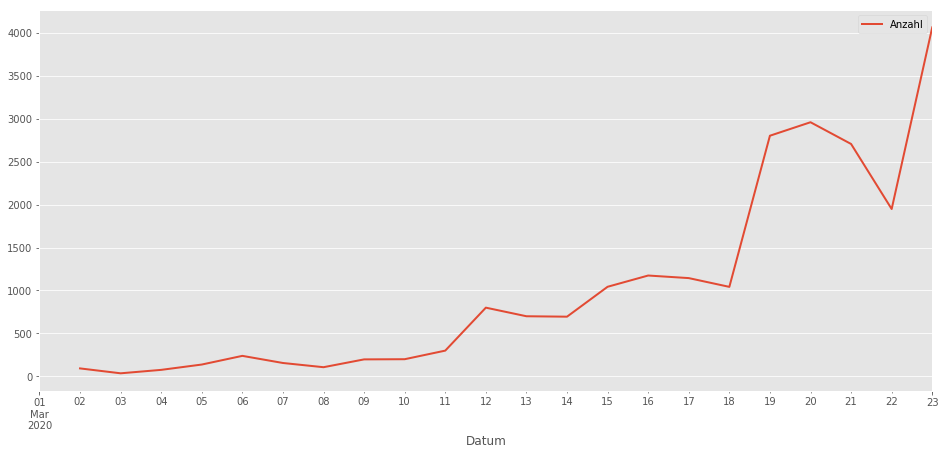

In [3]:
df_progression = df_cases.diff(axis=0)
df_progression.plot(figsize=(16,7))

## Rate der Neuinfektionen

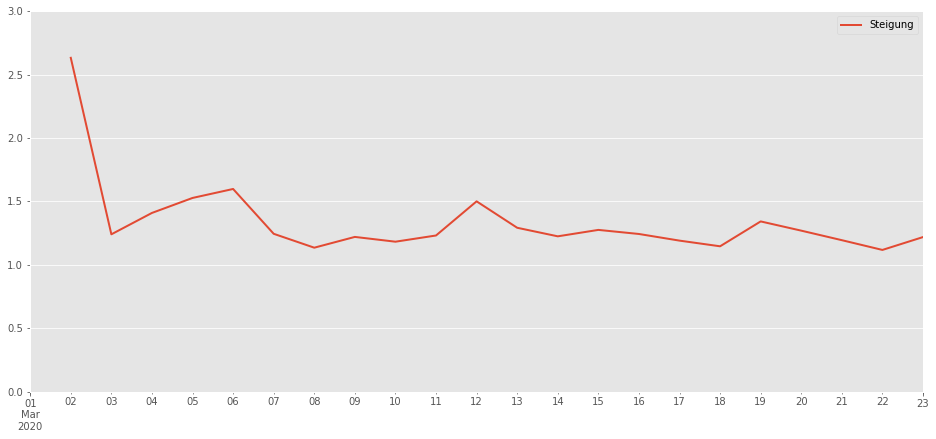

In [4]:
df_ratio = pd.DataFrame (columns = ['Steigung'])
lst = float('NaN')
for index, row in df_cases.iterrows():
    df_ratio.loc[index] = row['Anzahl']/lst
    lst = row['Anzahl']
ax = df_ratio.plot(figsize=(16,7), ylim=(0,3))

## Anzahl Gesamtfälle (akkumuliert)

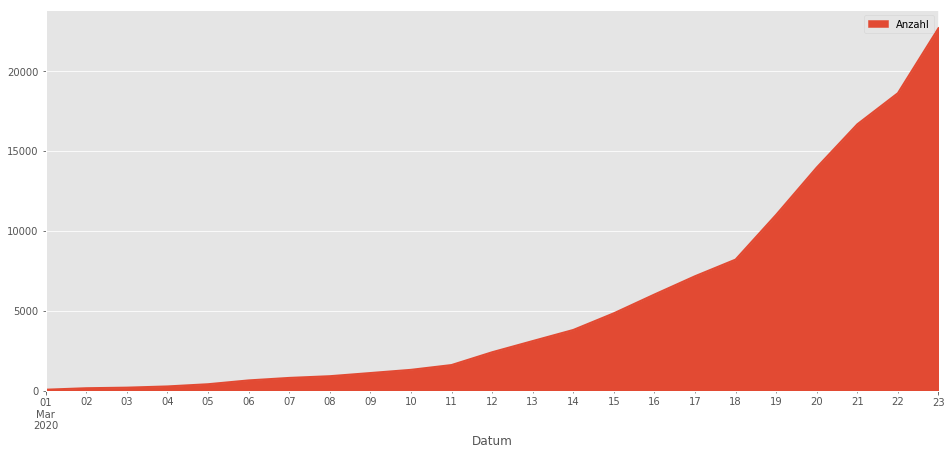

In [5]:
df_cases.plot.area(figsize=(16,7))

## Extrapolation der Zukünftigen Fallzahlen 

In [6]:
def extrapolate(idf, evalsize=0, extend=80):
    model = PolynomialModel(4)   
    num   = idf.shape[0]
    
    if evalsize != 0:
        if evalsize <= idf.shape[0]:
            num = evalsize
    
    count = num
    idf_input = pd.DataFrame(columns = ['RKI-Zahlen', 'Extrapolation'])
    for index, row in idf.iterrows():
        idf_input = idf_input.append(row)
        count -= 1
        if count <= 0:
            break

    xidx    = list(range(0, num))
    idf_x   = pd.DataFrame(xidx, columns = ['x'])
    idf_fit = idf_input.reset_index()
    
    params  = model.guess(idf_fit['Anzahl'], x=idf_x['x'])
    result  = model.fit(idf_fit['Anzahl'], params, x=idf_x['x'])

    xidx_predict = list(range(0, num + extend))
    predict_span = pd.DataFrame(xidx_predict, columns = ['x'])
    predict      = result.eval(x=predict_span['x'])
    
    idf_predict  = pd.DataFrame(columns = ['RKI-Zahlen', 'Extrapolation'])
    first_date   = idf.head(1).index
    
    i = 0
    for val in predict:
        idx = first_date + pd.Timedelta(i, unit='D')
        if i < num:
            rki = idf['Anzahl']
        else:
            rki = float('NaN')

        idf_predict = idf_predict.append(
                        pd.DataFrame({
                            'RKI-Zahlen':    rki,
                            'Extrapolation': val},
                            index=idx))
        i += 1
    return idf_predict

df_predict = extrapolate(df_cases)

## Kurzzeit-Simulation

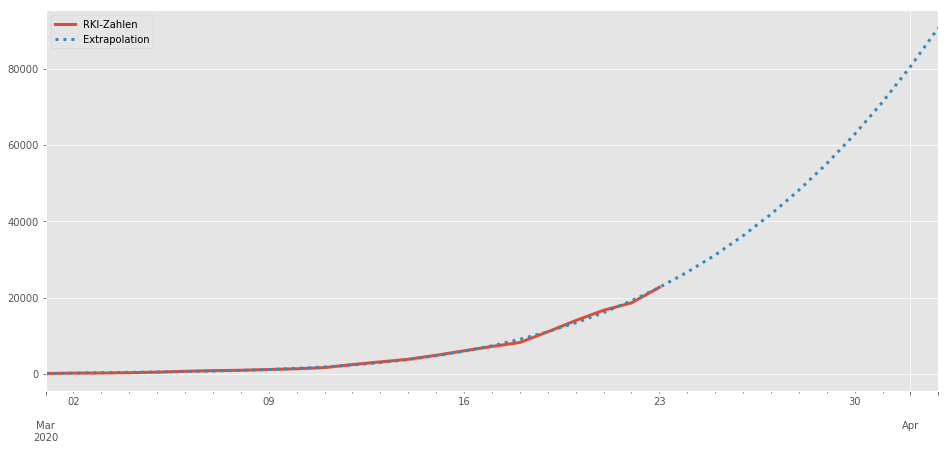

In [7]:
df_predict[:-70].plot(figsize=(16,7), style=['-',':'], linewidth=3)

## Längerer Ausblick (hohe Unsicherheit)

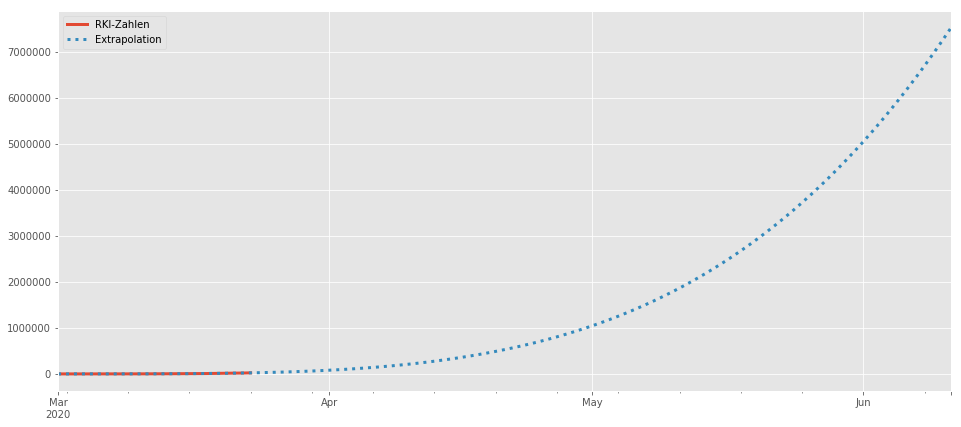

In [8]:
df_predict.plot(figsize=(16,7), style=['-',':'], linewidth=3)

## Abschätzung der Menge der infizierten Personen

### Annahme: Infektionsdauer (Krankheit) 17 Tage

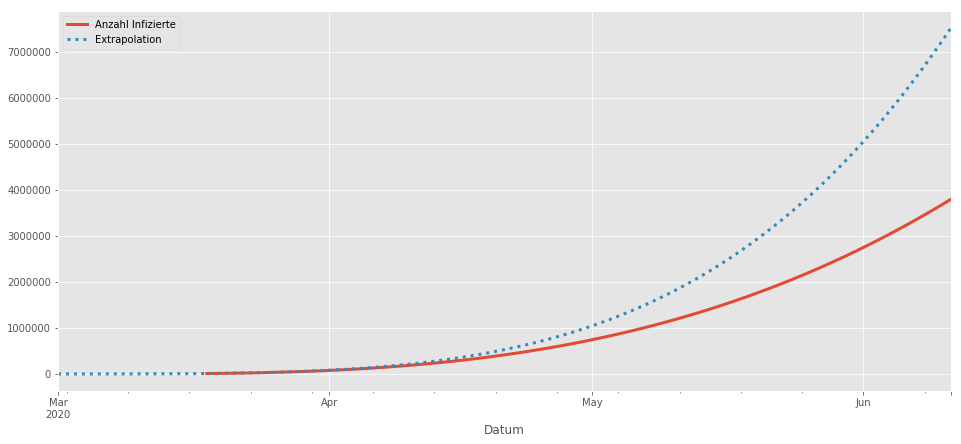

In [9]:
df_pred_single = pd.DataFrame(columns = ['Datum', 'Anzahl Infizierte', 'Extrapolation'])
sickness_duration = 17
i = 0
for index, row in df_predict.iterrows():
    extrapol = row['Extrapolation']
    
    if i < sickness_duration:
        infected = float('NaN')
    else:
        infected = row['Extrapolation'] - df_predict.iloc[i-sickness_duration]['Extrapolation']
        
    df_pred_single.loc[i] = [pd.to_datetime(index), infected, extrapol]
    i += 1

df_pred_single.set_index('Datum', inplace=True)
ax = df_pred_single.plot(figsize=(16,7), style=['-',':'], linewidth=3)

## Entwicklung der Vorhersagen über die letzten 5 Tage

In [10]:
days  = df_cases.shape[0]
df_p5 = extrapolate(df_cases, evalsize=days-5, extend=80+5).rename(columns={"Extrapolation": "Vor 5 Tagen"}).drop(['RKI-Zahlen'], axis=1)
df_p4 = extrapolate(df_cases, evalsize=days-4, extend=80+4).rename(columns={"Extrapolation": "Vor 4 Tagen"}).drop(['RKI-Zahlen'], axis=1)
df_p3 = extrapolate(df_cases, evalsize=days-3, extend=80+3).rename(columns={"Extrapolation": "Vor 3 Tagen"}).drop(['RKI-Zahlen'], axis=1)
df_p2 = extrapolate(df_cases, evalsize=days-2, extend=80+2).rename(columns={"Extrapolation": "Vor 2 Tagen"}).drop(['RKI-Zahlen'], axis=1)
df_p1 = extrapolate(df_cases, evalsize=days-1, extend=80+1).rename(columns={"Extrapolation": "Vor 1 Tag"}).drop(['RKI-Zahlen'], axis=1)
df_p0 = extrapolate(df_cases, evalsize=days-0, extend=80+0).rename(columns={"Extrapolation": "aktuell"}).drop(['RKI-Zahlen'], axis=1)
df_pset = pd.concat([df_p5, df_p4, df_p3, df_p2, df_p1, df_p0], axis=1)

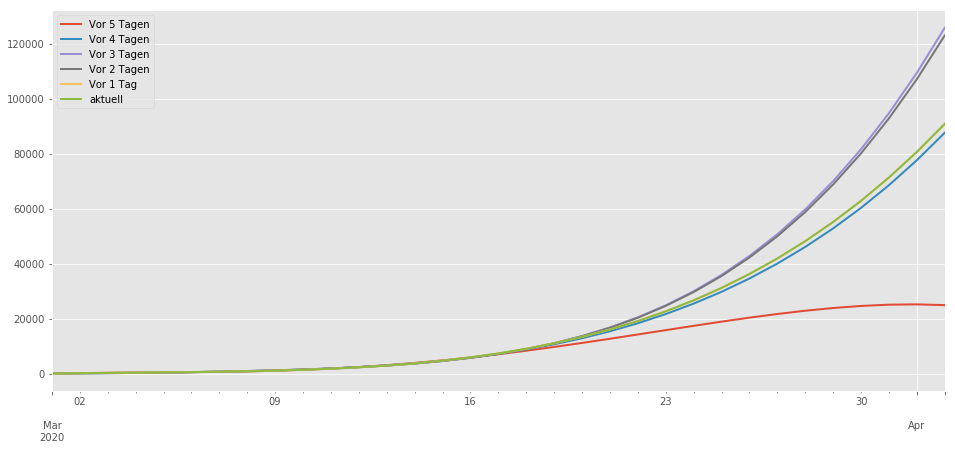

In [11]:
#df_pset.plot(figsize=(16,7), color=['#ff9999','#dd6666','#cc4444','#aa3333','#882233', '#550000'])
df_pset[:-70].plot(figsize=(16,7))